In [76]:
# Étape 0 : Importer les librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

In [77]:
df = pd.read_csv('8_air_qualite.csv', sep=';', decimal=',')

df.rename(columns=lambda x: x.strip(), inplace=True)

# Convertir 'Date' en datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date'])

In [78]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18.00.00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,2004-03-10,19.00.00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,2004-03-10,20.00.00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,2004-03-10,21.00.00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,2004-03-10,22.00.00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [79]:
# Choix de colonnes
cols = ['CO(GT)','RH']
## RH représente l'himidité
df[cols] = df[cols].replace(-200, 0)
df[cols] = df[cols].fillna(0)
# Agréger par jour (moyenne journalière)
df_daily = df.groupby('Date')[cols].mean()
df_daily.head()

,CO(GT),RH
Date,,
2004-03-10,1.966667,54.900000
2004-03-11,2.145833,64.075000
2004-03-12,2.570833,51.095833
2004-03-13,2.583333,51.533333
2004-03-14,2.366667,48.850000


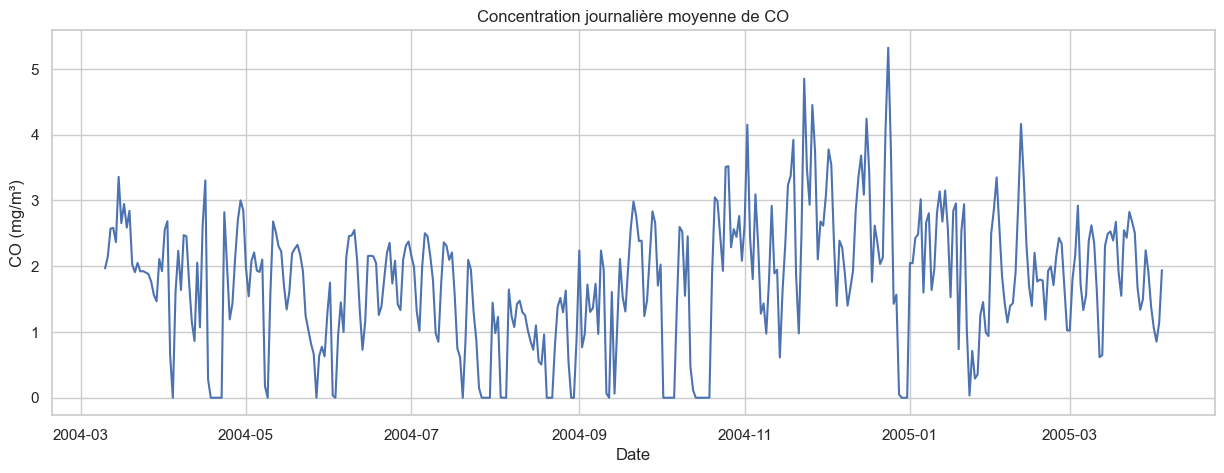

In [80]:
# Visualiser la série CO journalière
plt.figure(figsize=(15,5))
plt.plot(df_daily['CO(GT)'])
plt.title("Concentration journalière moyenne de CO")
plt.xlabel("Date")
plt.ylabel("CO (mg/m³)")
plt.show()

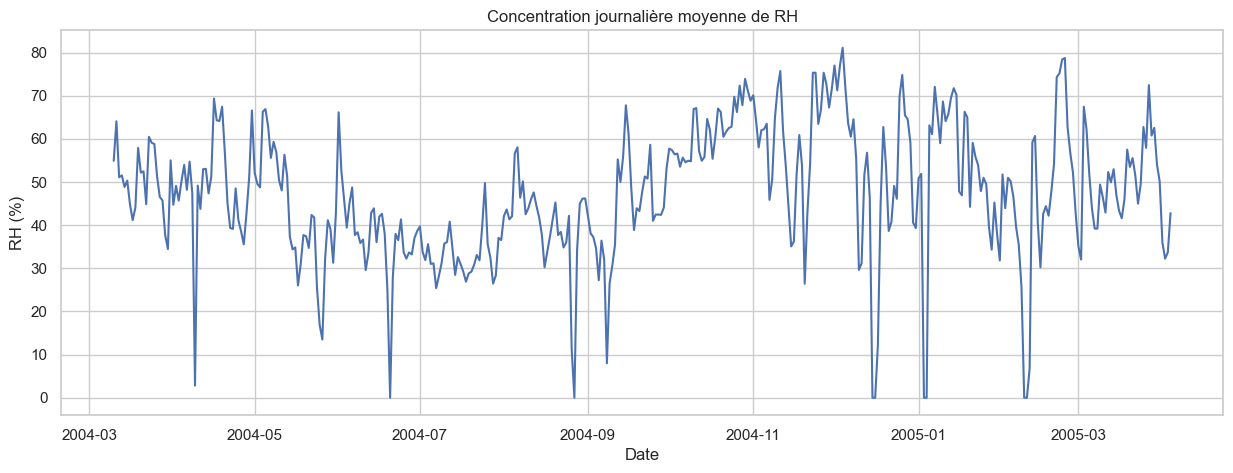

In [81]:
# Visualiser la série RH journalière
plt.figure(figsize=(15,5))
plt.plot(df_daily['RH'])
plt.title("Concentration journalière moyenne de RH")
plt.xlabel("Date")
plt.ylabel("RH (%)")
plt.show()

stationarite de CO

In [82]:
def adf_test(x):
    # Si DataFrame -> prendre la colonne AveragePrice
    if isinstance(x, pd.DataFrame):
        s = x["CO(GT)"]
    else:  # sinon c'est une Series
        s = x

    s = s.dropna()
    result = adfuller(s, autolag="AIC")

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Stationnaire" if result[1] < 0.05 else "NON stationnaire")

In [83]:
adf_test(df_daily["CO(GT)"])

ADF Statistic: -5.19425313637001
p-value: 9.032736837264583e-06
Stationnaire


In [84]:
def difference(series,order):
    return series.diff(order).dropna()

In [85]:
data_diff_1 = difference(df_daily["CO(GT)"],1)
#data_diff_2 = difference(data_diff_1,1)
# d = 2
adf_test(data_diff_1)

ADF Statistic: -8.710767776532135
p-value: 3.5963803646556553e-14
Stationnaire


<class 'pandas.core.series.Series'>


<Figure size 1000x400 with 0 Axes>

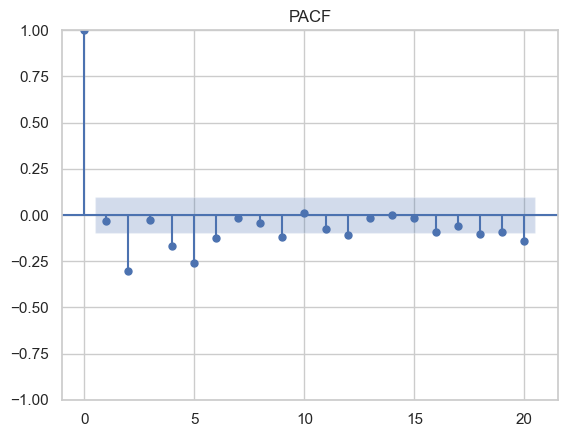

<Figure size 1000x400 with 0 Axes>

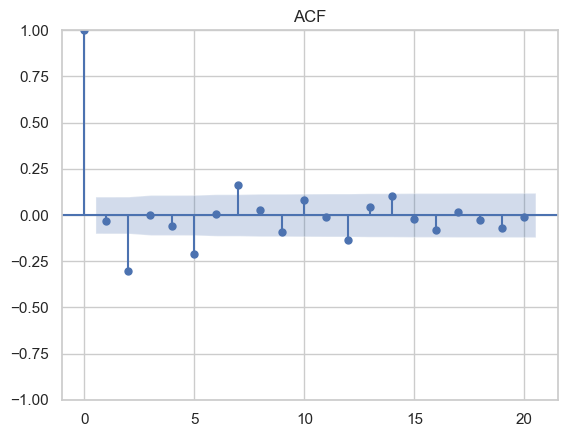

In [86]:
print(type(data_diff_1))
if isinstance(data_diff_1, pd.DataFrame):
    print(data_diff_1.columns)

# récupérer la série CO
if isinstance(data_diff_1, pd.DataFrame):
    s = data_diff_1.loc[:, "CO(GT)"]
else:
    s = data_diff_1  # déjà une Series

# tracer la PACF
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(10,4))
plot_pacf(s.dropna(), lags=20)
plt.title("PACF")
plt.show()
plt.figure(figsize=(10,4))
plot_acf(s.dropna(), lags=20)
plt.title("ACF")
plt.show()

In [87]:
# Split train/test
y = df_daily["CO(GT)"]
X = df_daily[["RH"]]

train_size = int(len(df_daily) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

In [88]:
# Recherche automatique des meilleurs paramètres SARIMAX
p = d = q = range(0, 3)       # valeurs possibles pour p, d, q
P = D = Q = range(0, 2)       # valeurs possibles pour P, D, Q
s = 12                    # saisonnalité hebdomadaire

In [89]:
best_aic = np.inf
best_order = None
best_seasonal_order = None

In [90]:
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(y_train, 
                            exog= X_train,
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = (seasonal_order[0], seasonal_order[1], seasonal_order[2], s)
        except:
            continue

In [91]:
print(f"Meilleurs paramètres : order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

# Entraînement final avec les meilleurs paramètres
model = SARIMAX(y_train, exog=X_train,
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
sarimax_result = model.fit(disp=False)


Meilleurs paramètres : order=(1, 1, 2), seasonal_order=(0, 0, 1, 12), AIC=668.71


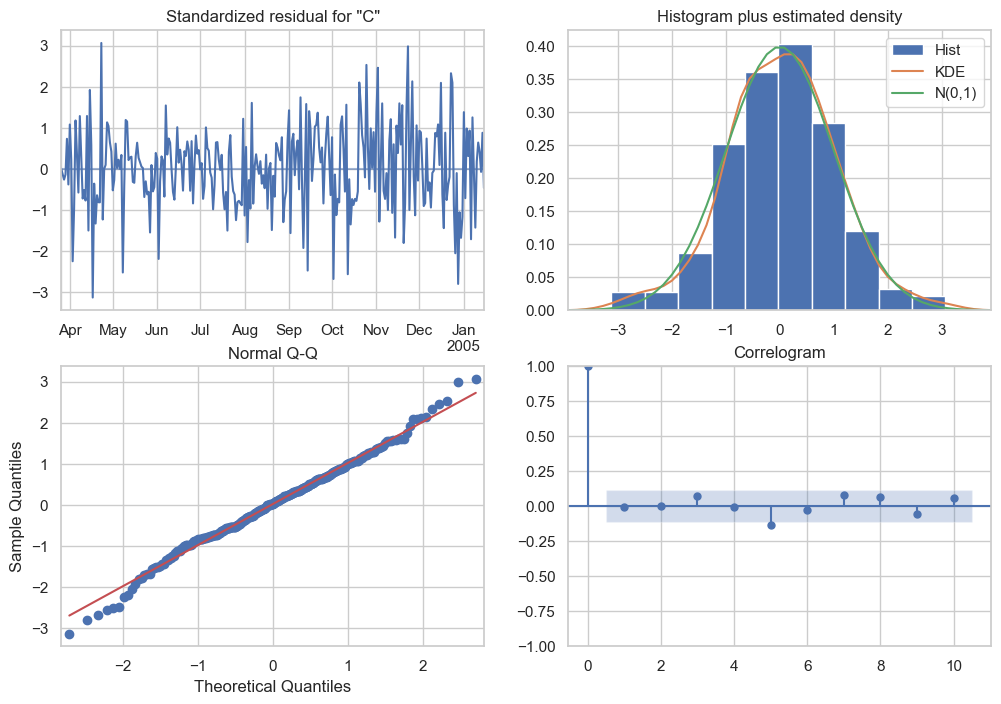

In [92]:
# Analyse des résidus
sarimax_result.plot_diagnostics(figsize=(12,8))
plt.show()


RMSE : 0.8974076894788758


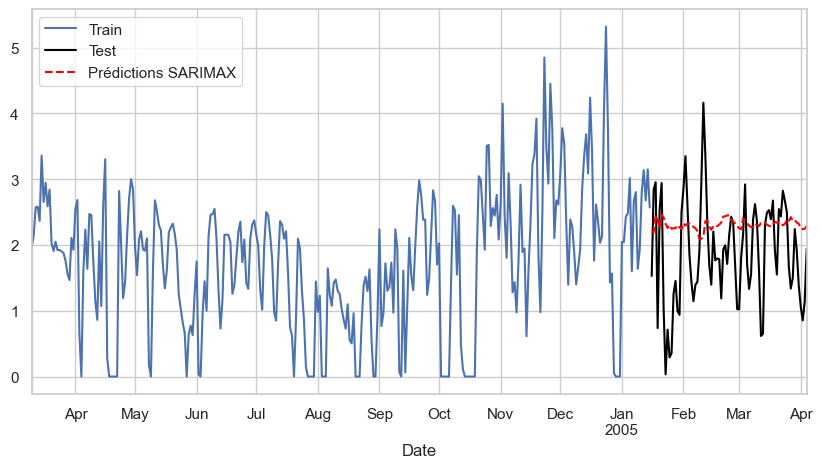

In [93]:
from sklearn.metrics import mean_squared_error

# Prédictions pour l'horizon de test (avec exog)
pred = sarimax_result.get_forecast(steps=len(y_test), exog=X_test)
y_pred = pred.predicted_mean

# Calcul du RMSE : calculer la MSE puis la racine (compatibilité scikit-learn)
# Assurer l'alignement des index entre y_test et y_pred
y_pred = pd.Series(y_pred.values, index=y_pred.index) if not isinstance(y_pred, pd.Series) else y_pred
y_pred = y_pred.reindex(y_test.index)
mse = mean_squared_error(y_test.values, y_pred.values)
rmse = np.sqrt(mse)
print("RMSE :", rmse)

# Visualisation des résultats
plt.figure(figsize=(10,5))
y_train.plot(label='Train')
y_test.plot(label='Test', color='black')
y_pred.plot(label='Prédictions SARIMAX', linestyle='--', color='red')
plt.legend()
plt.show()